In [1]:
# 코로나감염증 판별

import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:



from google.colab import drive

drive.mount('/content/gdrive/')  #구글드라이브를 코랩으로 마운트시키기

Mounted at /content/gdrive/


In [3]:
import shutil
import os

try:
  dataset_path = '/content/gdrive/My Drive/Colab Notebooks'
  shutil.copy(os.path.join(dataset_path, 'COVID-19_Radiography.zip'), '/content')  # 위 마운트 시킨 후, 파일 복사해오기

except Exception as err:
  print(str(err))

In [4]:
import os

ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'COVID-19_Radiography')   # DATA_ROOT_DIR = '/content/COVID-19_Radiography'
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')  # COVID-19_Radiography 아래 train폴더만들기  , TRAIN_DATA_ROOT_DIR = '/content/COVID-19_Radiography/train'
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')


In [5]:
import os
import shutil

if os.path.exists(DATA_ROOT_DIR):
  shutil.rmtree(DATA_ROOT_DIR)
  print(DATA_ROOT_DIR + 'is removed !!!')

In [6]:
import zipfile # 압축풀기

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'COVID-19_Radiography.zip'), 'r') as target_file:
  target_file.extractall(DATA_ROOT_DIR)   # DATA_ROOT_DIR =>> /content/COVID-19_Radiography

In [7]:
import shutil
import os
import glob

total_file_list = glob.glob(os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset/*'))    # DATA_ROOT_DIR = '/content/COVID-19_Radiography'

label_name_list = [ file_name.split('/')[-1].strip() for file_name in total_file_list if os.path.isdir(file_name) == True ]   # strip()   띄어쓰기(' '), 탭('\t'), 엔터('\n')를 없애기 위한 것  https://yeonkevin.tistory.com/85


for label_name in label_name_list:
  src_dir_path = os.path.join(DATA_ROOT_DIR,
                              'COVID-19_Radiography_Dataset' + '/'+label_name+'/images')
  dst_dir_path = os.path.join(DATA_ROOT_DIR, 'train'+'/'+label_name)      # train데이타만들기

  try:
    shutil.copytree(src_dir_path, dst_dir_path)
  except Exception as err:
    print(str(err))

if not os.path.exists(TEST_DATA_ROOT_DIR):
  os.mkdir(TEST_DATA_ROOT_DIR)

for label_name in label_name_list:

  if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, label_name)):
     os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))

# 여기까진 파일은 안들어가있음,  ..test/COVID/,, 텅 빈 폴더

In [8]:
import os
import shutil
import random

MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:

  src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)


  train_data_file_list = os.listdir(src_dir_path)

  random.shuffle(train_data_file_list)

  split_num = int(MOVE_RATIO*len(train_data_file_list))

  test_data_file_list = train_data_file_list[0:split_num]

  for test_data_file in test_data_file_list:

    try:
      shutil.move(os.path.join(src_dir_path, test_data_file),
                  os.path.join(dst_dir_path, test_data_file))
    except Exception as err:
      print(str(err))

In [10]:
#이미지데이터정규화

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                    color_mode='rgb', class_mode='sparse',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    subset='training')

validation_generator = validation_data_gen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32,
                                                               color_mode='rgb', class_mode='sparse',
                                                               target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                               subset='validation')

test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR,batch_size=32,
                                                  color_mode='rgb', class_mode='sparse',
                                                  target_size=(IMG_WIDTH,IMG_HEIGHT))

print(train_generator.class_indices, train_generator.num_classes)


Found 13548 images belonging to 4 classes.
Found 3385 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3} 4


In [ ]:
# 모델생성 후 여기까지 작업 후, 저 아래에서 확인작업

In [12]:
IMG_NUMS = 16

image_data, label_data = train_generator.next()

data = image_data[:IMG_NUMS]
label = label_data[:IMG_NUMS]

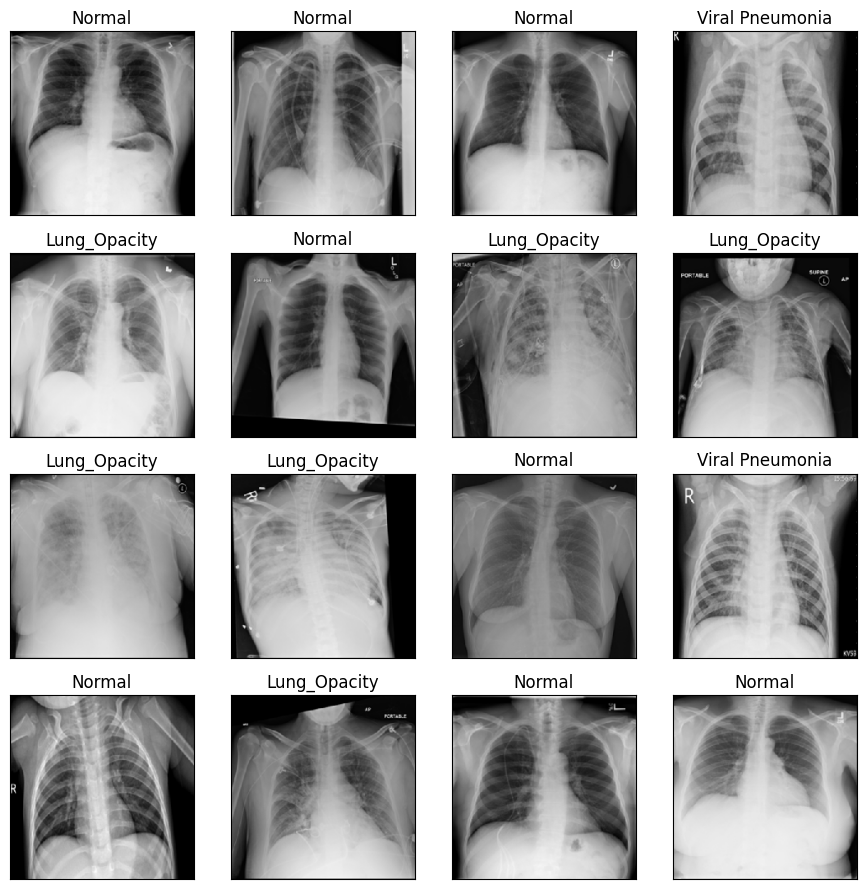

In [13]:
import matplotlib.pyplot as plt
class_dict = {0:'COVID', 1:'Lung_Opacity', 2: 'Normal', 3:'Viral Pneumonia'}

plt.figure(figsize=(9,9))

for i in range(len(label)):
  plt.subplot(4,4, i+1)
  plt.title(str(class_dict[label[i]]))
  plt.xticks([]); plt.yticks([])

  plt.imshow(data[i])

plt.tight_layout()
plt.show()

In [14]:
# 전이학습 MobileNet

class_nums = train_generator.num_classes
pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT,3))

model = Sequential()

model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(class_nums, activation='softmax'))

model.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                         

In [15]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['acc'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping


earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)    # 모니터링할 것은 val_loss

hist = model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
424/424 [==============================] - 97s 150ms/step - loss: 0.6942 - acc: 0.7397 - val_loss: 0.3997 - val_acc: 0.8455
Epoch 2/20
424/424 [==============================] - 63s 148ms/step - loss: 0.3534 - acc: 0.8750 - val_loss: 0.2270 - val_acc: 0.9170
Epoch 3/20
424/424 [==============================] - 63s 148ms/step - loss: 0.2583 - acc: 0.9126 - val_loss: 0.2099 - val_acc: 0.9267
Epoch 4/20
424/424 [==============================] - 65s 153ms/step - loss: 0.2090 - acc: 0.9250 - val_loss: 0.2064 - val_acc: 0.9241
Epoch 5/20
424/424 [==============================] - 62s 146ms/step - loss: 0.1752 - acc: 0.9405 - val_loss: 0.1757 - val_acc: 0.9380
Epoch 6/20
424/424 [==============================] - 63s 147ms/step - loss: 0.1478 - acc: 0.9480 - val_loss: 0.1794 - val_acc: 0.9356
Epoch 7/20
424/424 [==============================] - 62s 146ms/step - loss: 0.1150 - acc: 0.9583 - val_loss: 0.1880 - val_acc: 0.9391
Epoch 8/20
424/424 [==============================] - 6

In [17]:
!mkdir -p saved_model
model.save('saved_model/my_model')

#****************************************

# https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko

In [18]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

#***********************************
#my_model
#assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables  // 이렇게 다섯개 폴더와파일나옴

my_model
assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [19]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3,294,724
Trainable params: 3,272,836
Non-

In [20]:
# Evaluate the restored model

new_model.evaluate(test_generator)
loss, acc = new_model.evaluate(test_generator, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(test_generator).shape)

133/133 [==============================] - 14s 102ms/step - loss: 0.2828 - acc: 0.9393
133/133 - 13s - loss: 0.2828 - acc: 0.9393 - 13s/epoch - 96ms/step
Restored model, accuracy: 93.93%
133/133 [==============================] - 14s 99ms/step
(4232, 4)


In [ ]:
# 아래는 h5로 저장 , 위는 save.model로 저장

In [ ]:
model.save('covid_model.h5')  #// 모델저장잘됨

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3,294,724
Trainable params: 3,272,836
Non-

In [ ]:
# 두번째는 여기서부터 작업

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.12.0


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('covid_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 3,294,724
Trainable params: 3,272,836
Non-

In [ ]:
new_model.evaluate(test_generator)

133/133 [==============================] - 13s 97ms/step - loss: 0.2701 - acc: 0.9454


[0.2700807452201843, 0.9454158544540405]

In [ ]:
# test_generator 위 이 폴더생성 후 하면 모델이 작동함




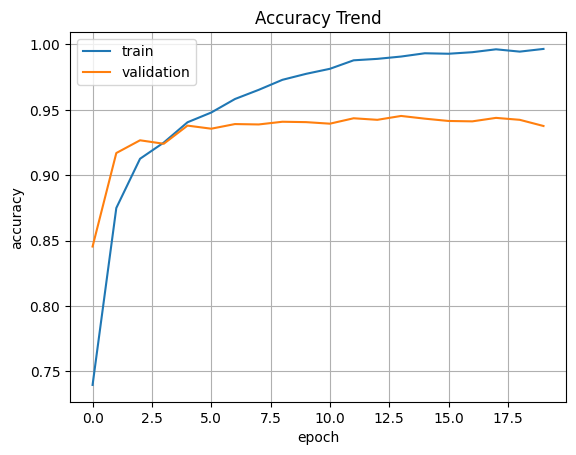

In [21]:
import matplotlib.pyplot as plt

plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label = 'validation')
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()

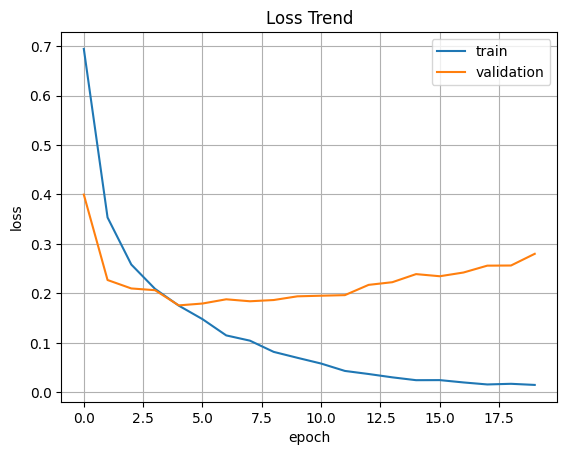

In [22]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label = 'validation')
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.grid()
plt.show()